In [1]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.animation as animation

In [2]:
import seaborn as sns
%matplotlib inline
from celluloid import Camera
from IPython.display import HTML

In [3]:
def plot_layer(layer_values, title):
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        #plt.colorbar()
        #plt.show()

In [4]:
lif1 = snn.Leaky(beta=0.9)

In [5]:
# dataloader arguments
batch_size = 128
data_path='\data\mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

In [7]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [8]:
num = 10
# Network Architecture
num_inputs = 28*28
num_hidden = 100
num_outputs = 10

# Temporal Dynamics
num_steps = 70
beta = 0.99

In [505]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)
        
    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []
        spk1_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            spk1_rec.append(spk1)
            spk2_rec.append(spk2) 
            mem2_rec.append(mem2)
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0), torch.stack(spk1_rec, dim=0)
        
# Load the network onto CUDA if available
net = Net().to(device)

In [506]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _, h_spk = net(data.view(num_steps, batch_size, 784))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())
    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(spike_data, targets, train=True)
    print_batch_accuracy(test_spk_data, test_targets, train=False)
    print("\n")

In [507]:
loss = nn.CrossEntropyLoss()

In [508]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3, betas=(0.9, 0.999))

In [509]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

In [510]:
# save all weights
backup = []
for i in range(num_hidden):
    for j in range(28*28):
        backup.append(net.fc1.weight.data[i,j].clone())

In [511]:
# set unchanging weight
target=[]
for i in range(78):
    target += list(range(i*1000, i*1000+500))

In [519]:
num_epochs = 1
loss_hist = []

# Weight list
weight_hist1 = [] 
weight_hist2 = []

test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        spike_data = spikegen.rate(data, num_steps=num_steps, gain=0.02)
        
        # forward pass
        net.train()
        spk_rec, mem_rec, hidden_spk = net(spike_data.view(num_steps, batch_size, 784))
        
        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        
        ## fix weights
        """
        for i in range(num_hidden):
            for j in range(784):
                if (i*784+j)%2 == 0:
                    net.fc1.weight.data[i,j] = backup[i*784+j]
        
        for num in target:
            i = num//784
            j = num%784
            net.fc1.weight.data[i,j] = backup[num]
        """
        
        # list에 weight 저장
        weight_hist1.append(net.fc1.weight.data.clone())
        weight_hist2.append(net.fc2.weight.data.clone())
        
        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)
            test_spk_data = spikegen.rate(test_data, num_steps=num_steps, gain=0.02)

            # Test set forward pass
            test_spk, test_mem, _ = net(test_spk_data.view(num_steps, batch_size, 784))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())
            
            # iteration이 50의 배수일 때 loss/accuraccy/weight 출력
            if counter % 50 == 0:
                train_printer()                
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 76.91
Test Set Loss: 74.18
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 84.38%


Epoch 0, Iteration 50
Train Set Loss: 60.60
Test Set Loss: 75.09
Train set accuracy for a single minibatch: 86.72%
Test set accuracy for a single minibatch: 80.47%


Epoch 0, Iteration 100
Train Set Loss: 67.01
Test Set Loss: 64.25
Train set accuracy for a single minibatch: 89.06%
Test set accuracy for a single minibatch: 85.16%


Epoch 0, Iteration 150
Train Set Loss: 56.50
Test Set Loss: 57.48
Train set accuracy for a single minibatch: 89.06%
Test set accuracy for a single minibatch: 89.84%


Epoch 0, Iteration 200
Train Set Loss: 85.71
Test Set Loss: 69.26
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 89.06%


Epoch 0, Iteration 250
Train Set Loss: 58.84
Test Set Loss: 74.66
Train set accuracy for a single minibatch: 86.72%
Test set accuracy for a single minibatch: 88.28%


E

In [535]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)
    spike_data = spikegen.rate(data, num_steps=num_steps, gain=0.02)

    # forward pass
    test_spk, _, hidden_spk = net(spike_data.view(70 ,data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 8830/10000
Test Set Accuracy: 88.30%


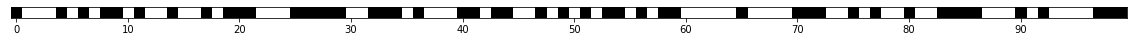

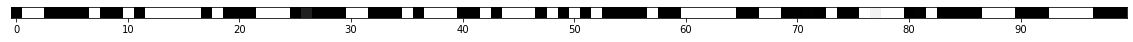

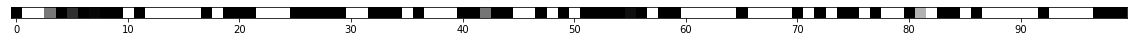

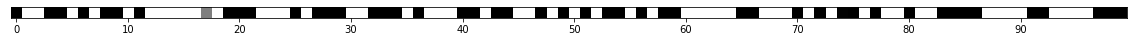

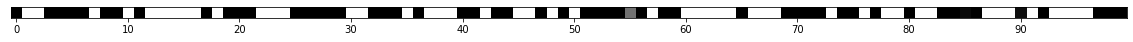

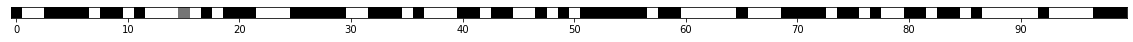

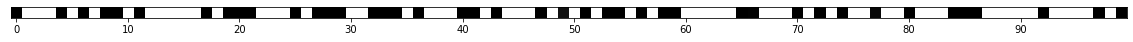

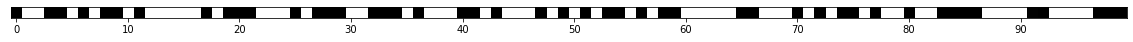

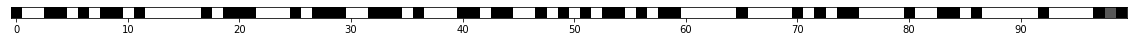

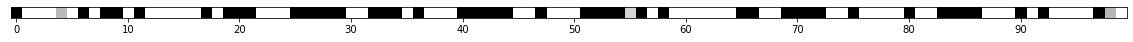

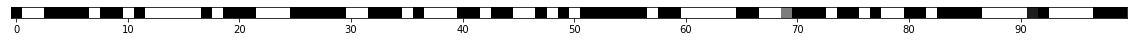

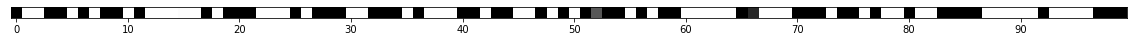

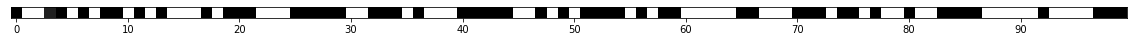

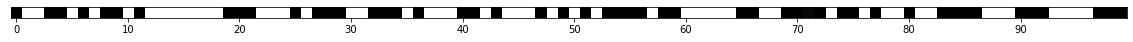

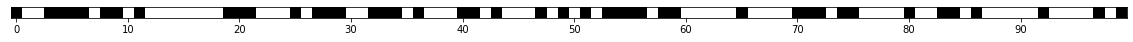

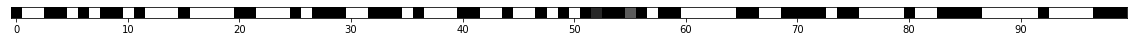

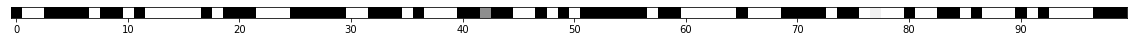

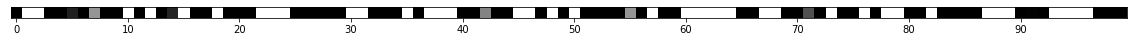

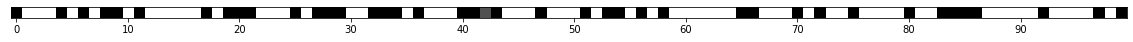

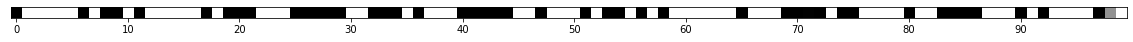

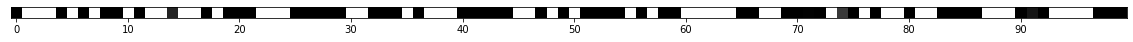

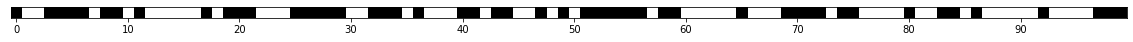

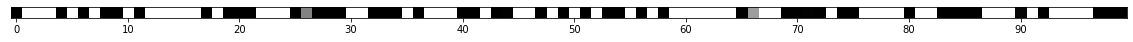

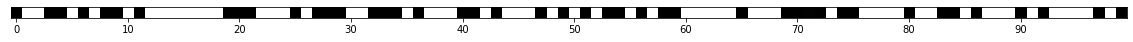

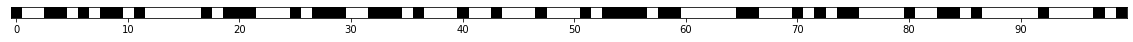

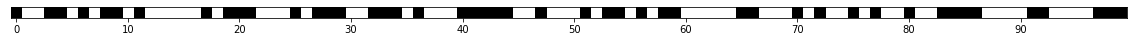

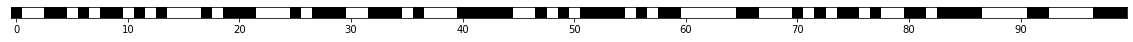

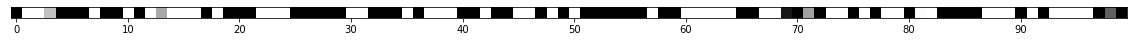

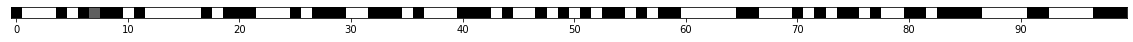

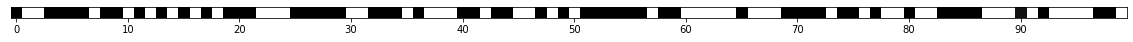

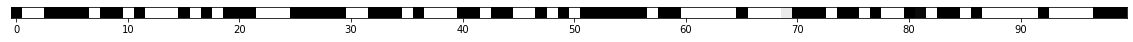

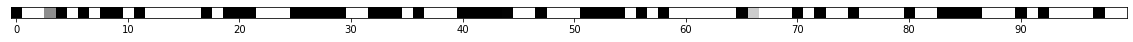

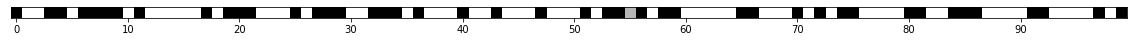

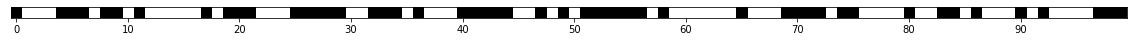

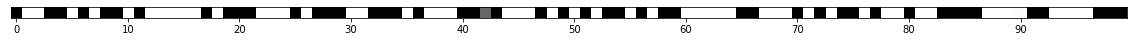

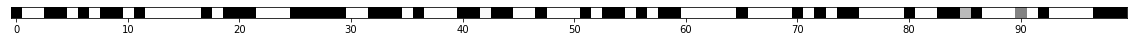

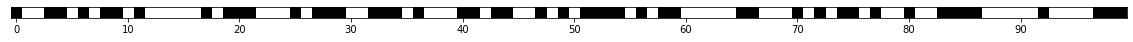

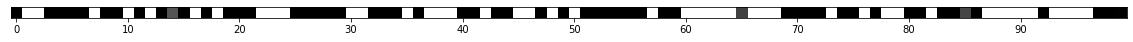

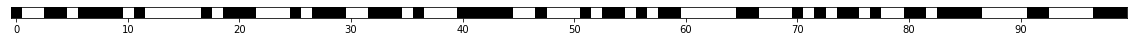

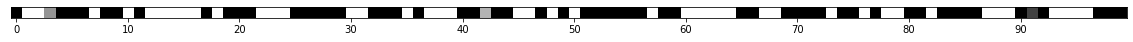

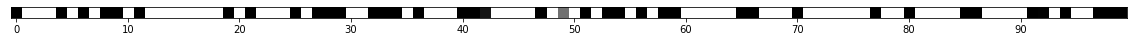

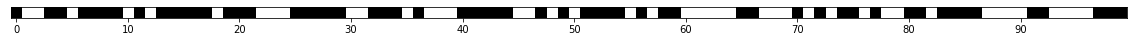

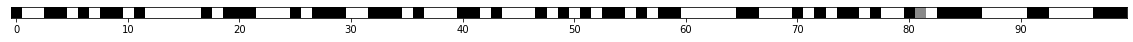

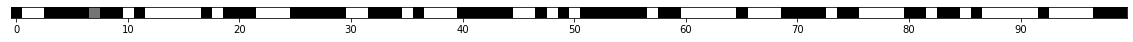

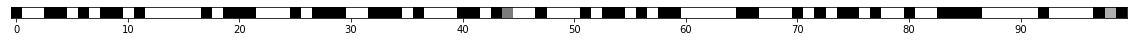

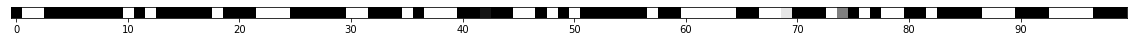

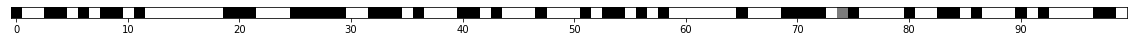

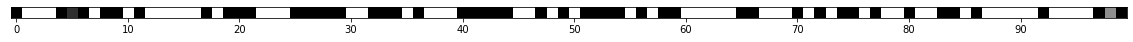

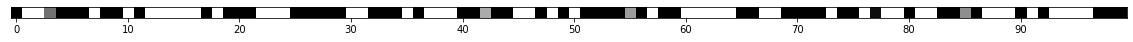

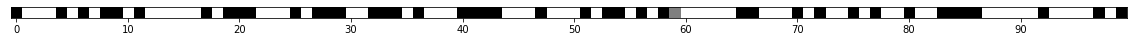

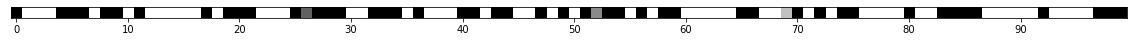

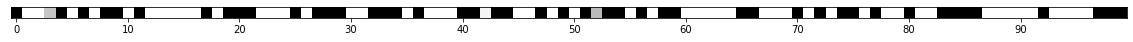

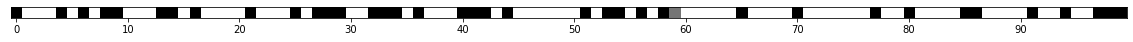

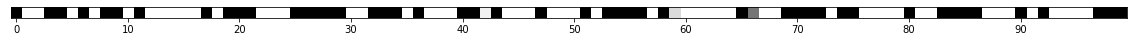

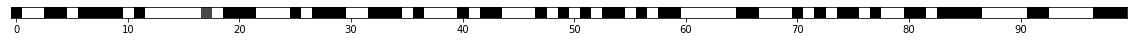

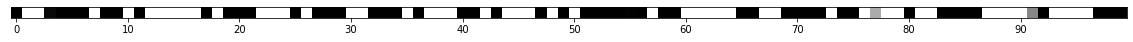

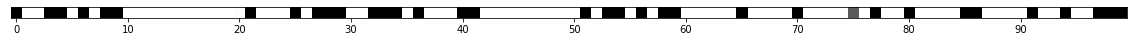

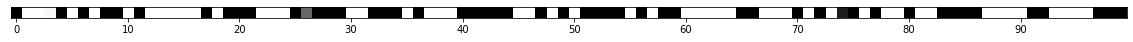

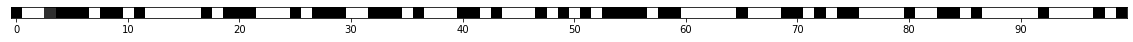

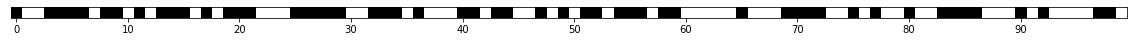

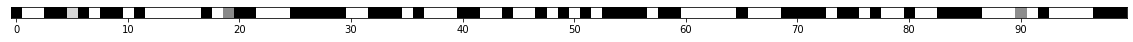

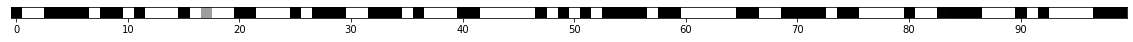

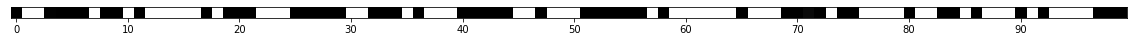

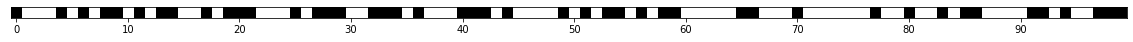

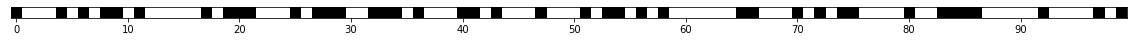

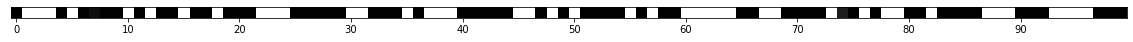

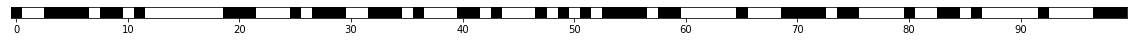

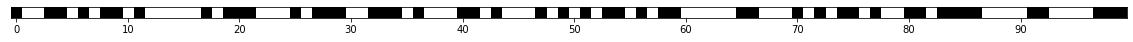

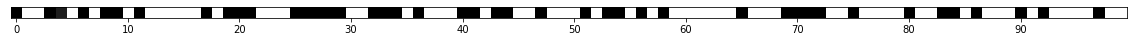

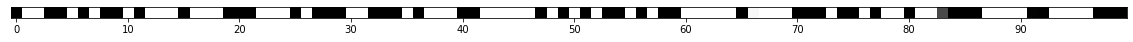

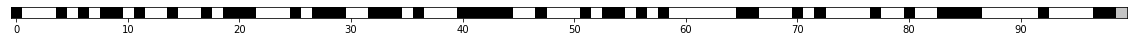

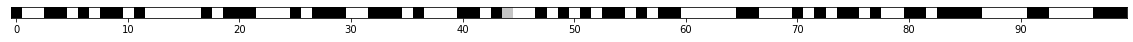

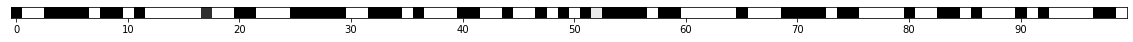

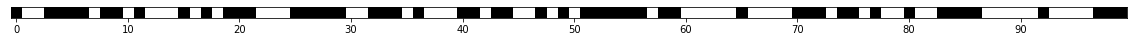

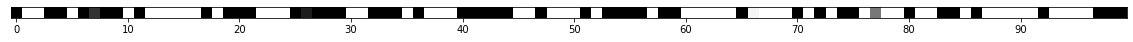

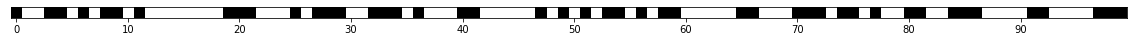

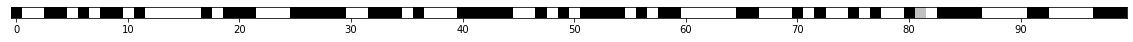

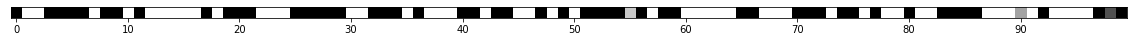

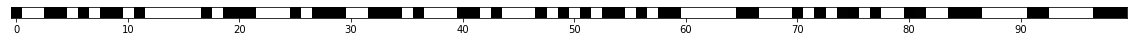

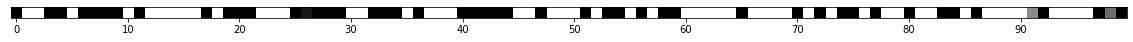

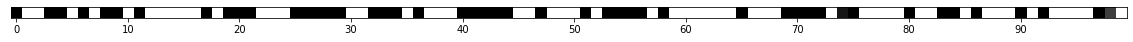

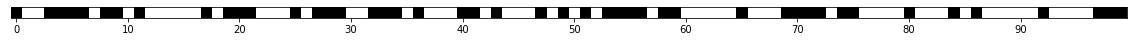

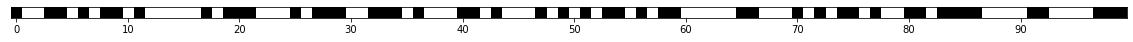

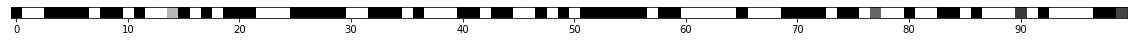

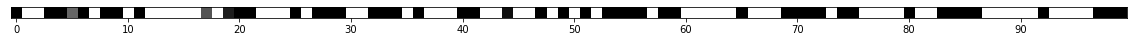

In [443]:
for i in range(1000):
    data = mnist_test.data[i].float()
    targets = mnist_test.targets[i].float()
    if targets == 0:
        spike_data = spikegen.rate(data, num_steps=num_steps, gain=0.1)
        test_spk, _, hidden_spk = net(spike_data.view(70,-1))
        _, predicted = test_spk.sum(dim=0).max(0)
        plt.figure(figsize=(20,1))
        plt.imshow(hidden_spk.sum(dim=0).unsqueeze(0).detach().numpy(), interpolation="nearest", cmap=plt.cm.binary)
        plt.yticks([])
        plt.xticks(np.arange(0,10)*10)
        #plt.colorbar()
        #plt.savefig("hidden_spike_sum.png")
        plt.show()

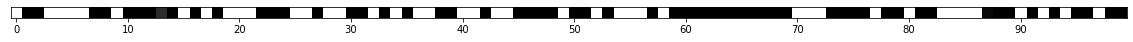

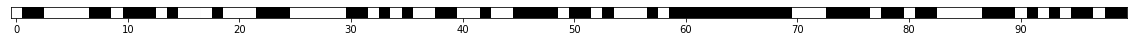

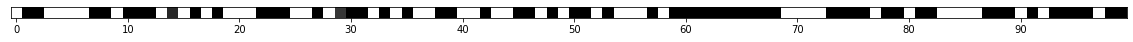

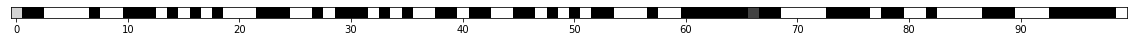

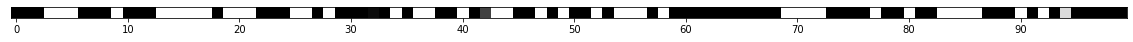

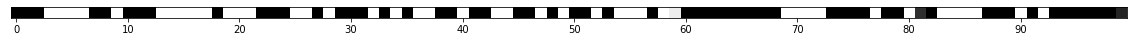

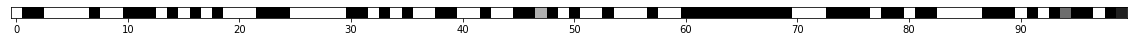

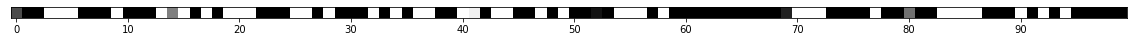

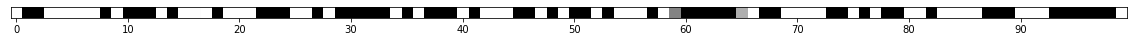

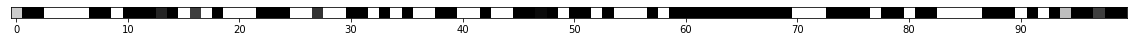

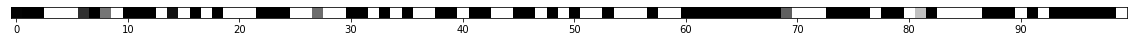

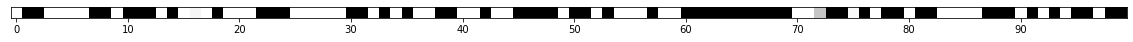

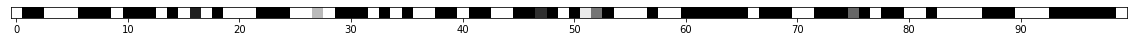

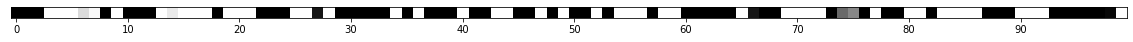

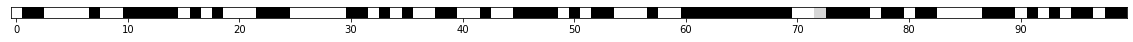

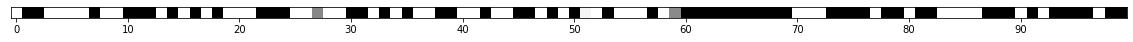

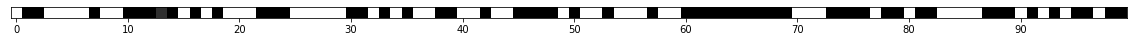

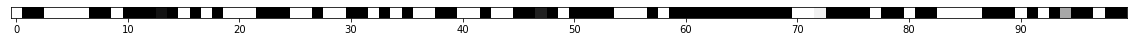

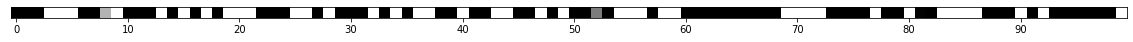

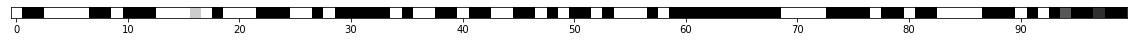

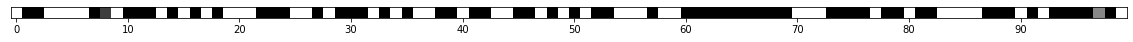

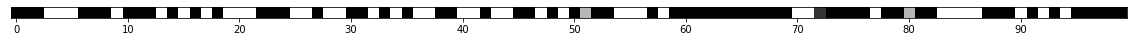

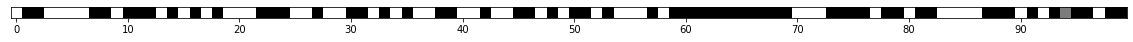

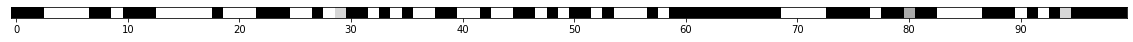

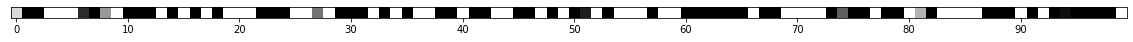

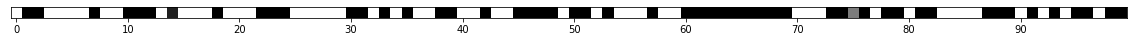

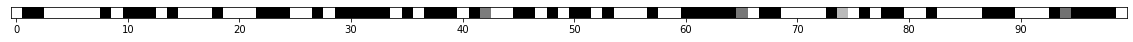

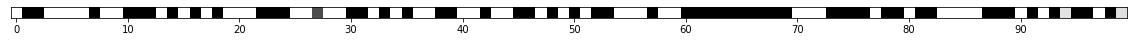

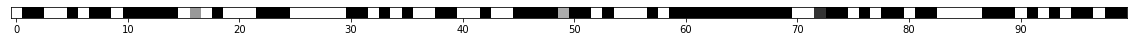

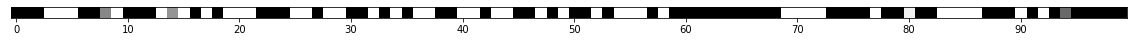

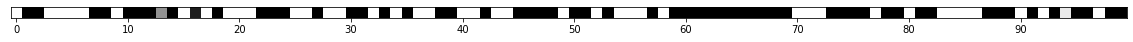

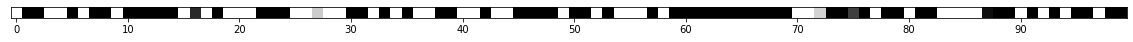

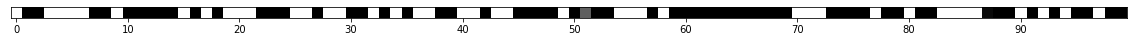

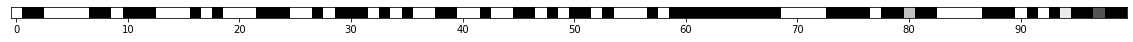

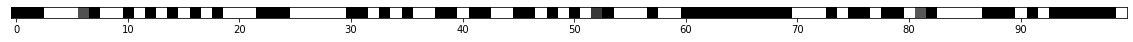

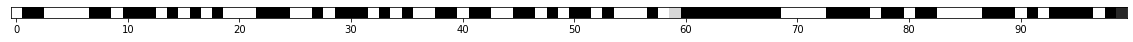

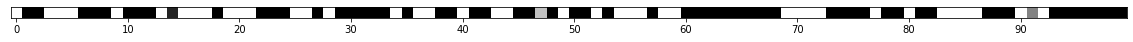

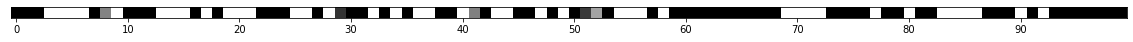

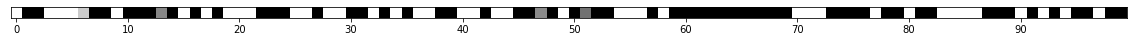

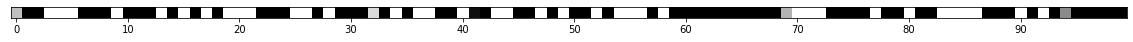

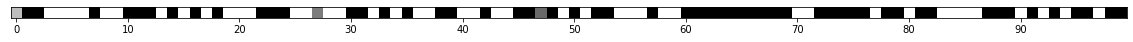

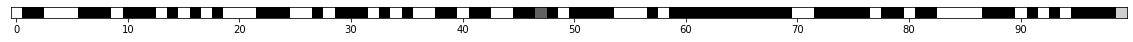

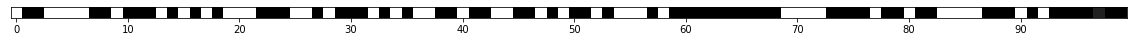

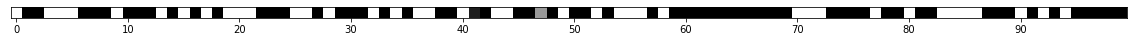

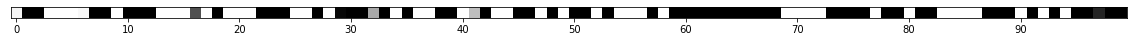

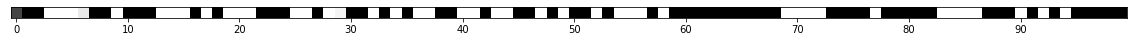

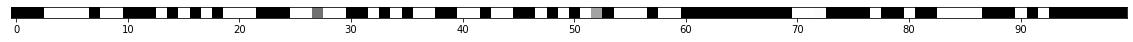

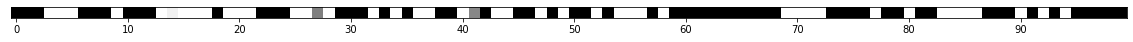

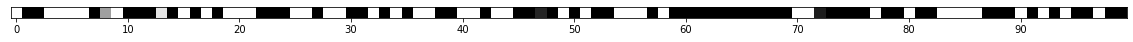

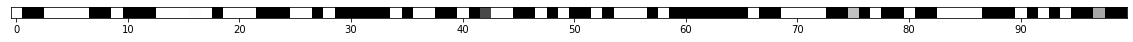

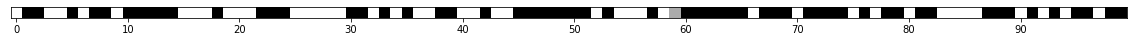

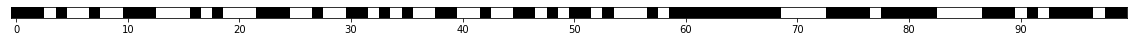

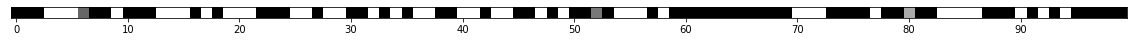

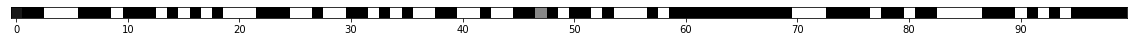

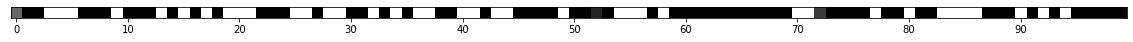

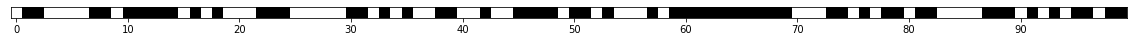

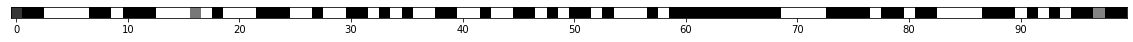

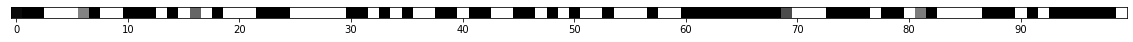

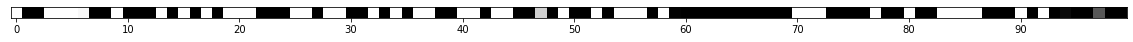

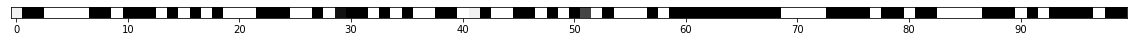

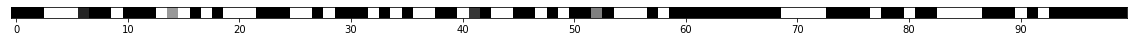

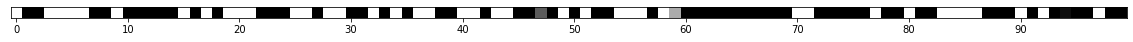

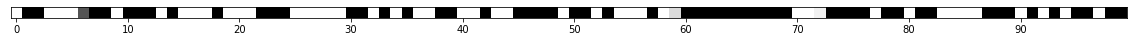

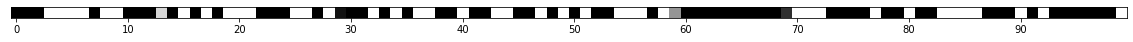

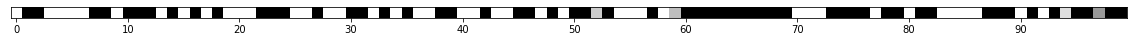

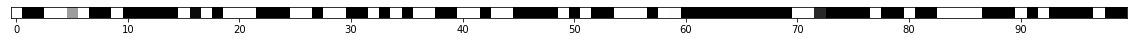

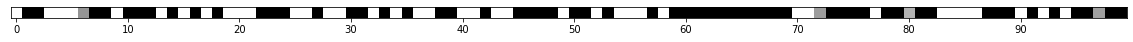

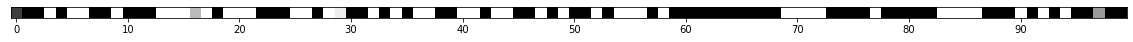

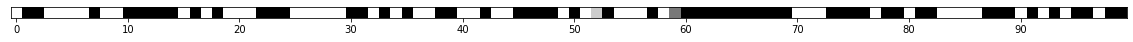

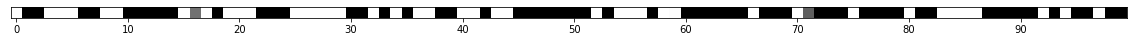

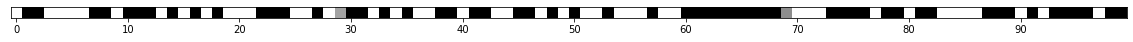

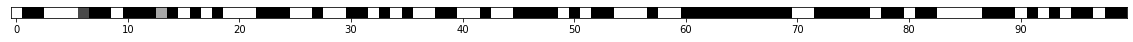

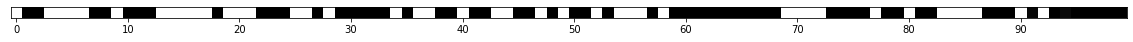

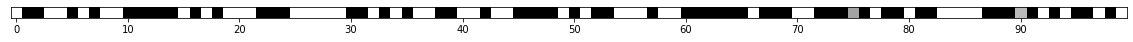

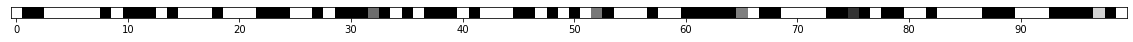

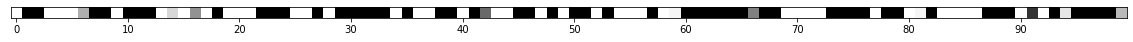

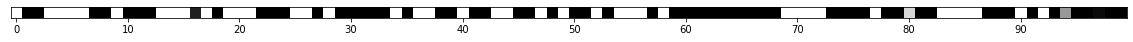

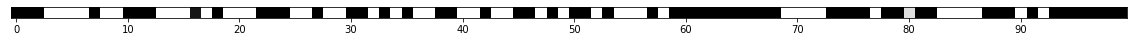

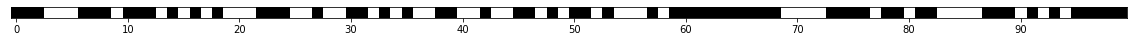

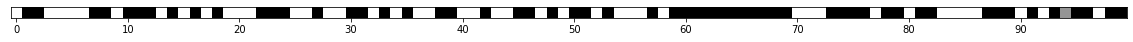

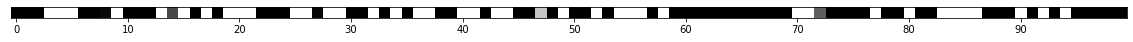

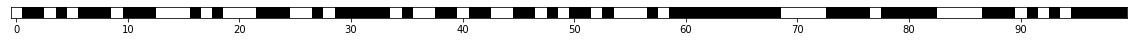

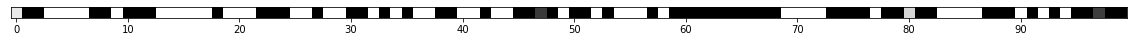

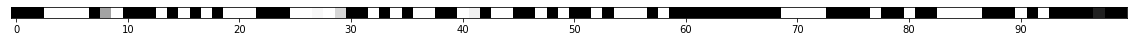

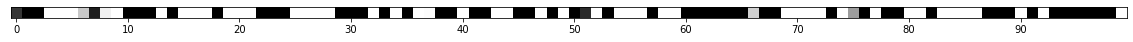

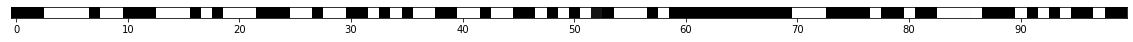

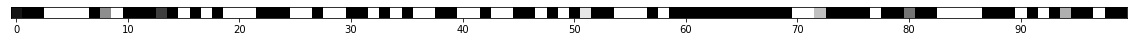

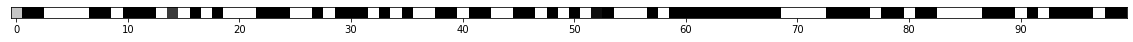

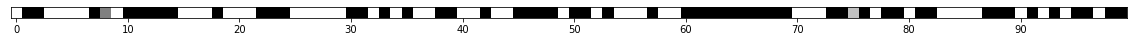

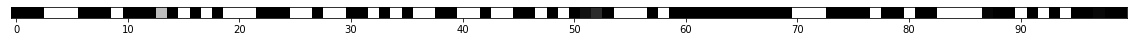

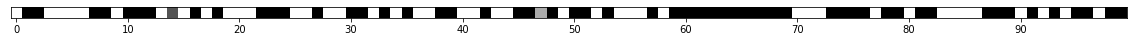

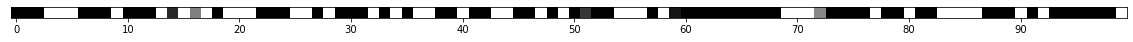

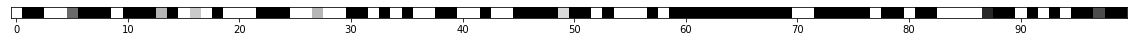

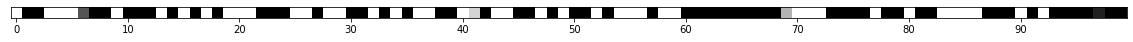

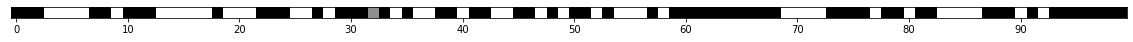

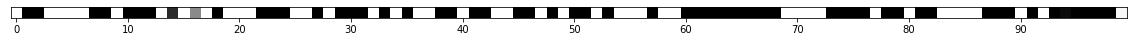

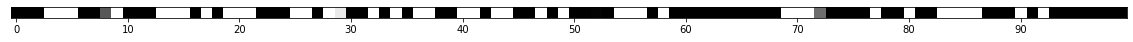

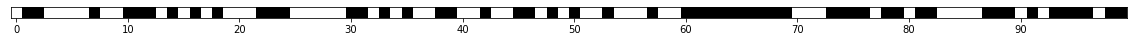

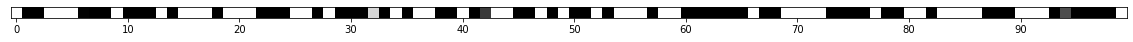

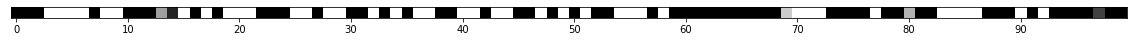

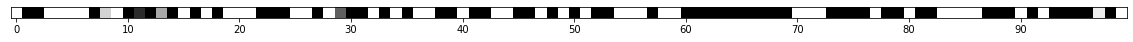

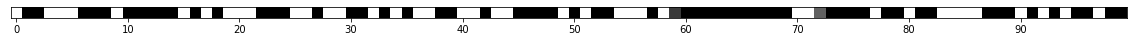

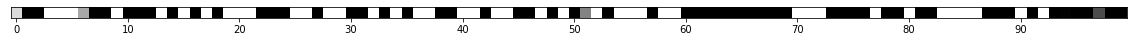

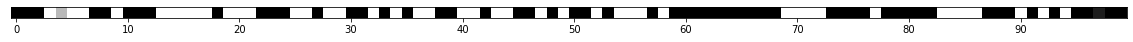

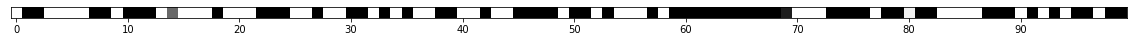

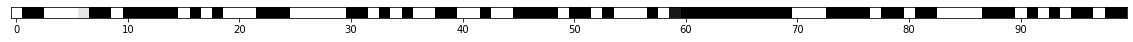

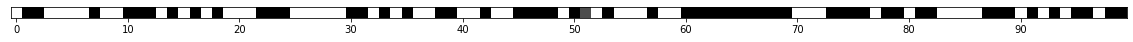

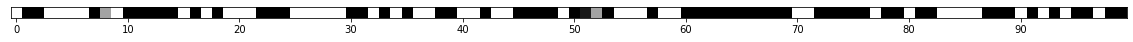

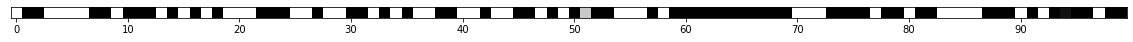

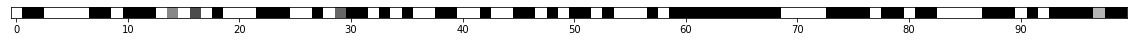

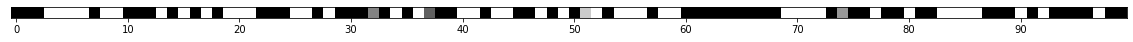

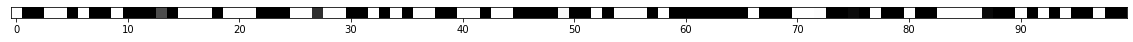

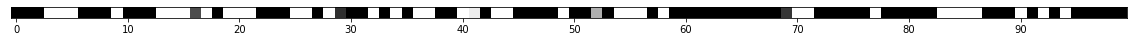

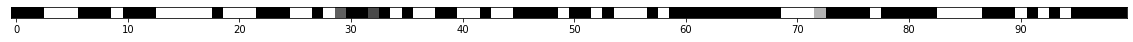

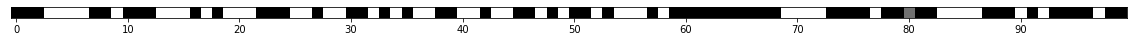

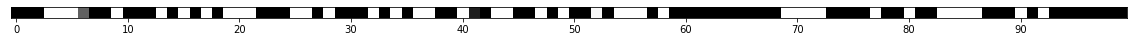

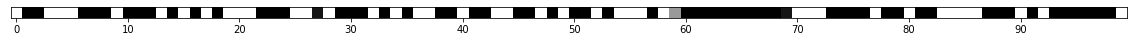

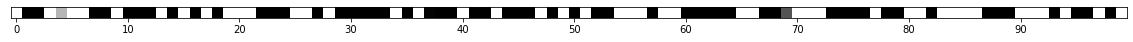

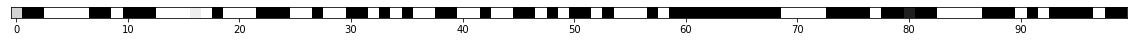

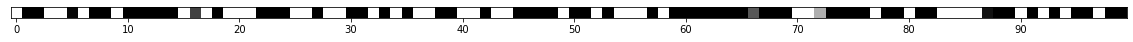

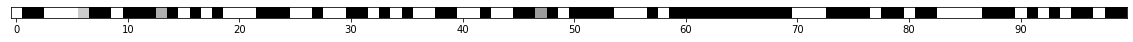

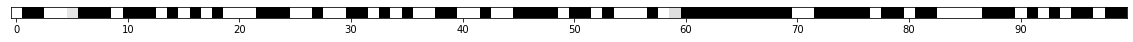

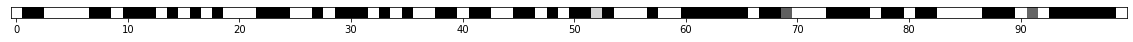

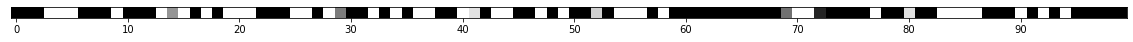

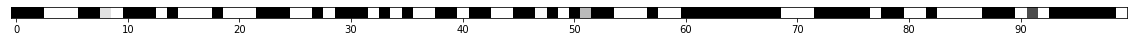

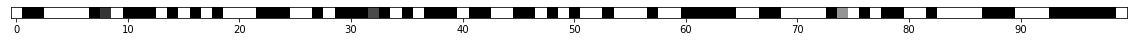

In [435]:
for i in range(1000):
    data = mnist_test.data[i].float()
    targets = mnist_test.targets[i].float()
    if targets == 1:
        spike_data = spikegen.rate(data, num_steps=num_steps, gain=0.1)
        test_spk, _, hidden_spk = net(spike_data.view(70,-1))
        _, predicted = test_spk.sum(dim=0).max(0)
        plt.figure(figsize=(20,1))
        plt.imshow(hidden_spk.sum(dim=0).unsqueeze(0).detach().numpy(), interpolation="nearest", cmap=plt.cm.gray)
        plt.yticks([])
        plt.xticks(np.arange(0,10)*10)
        #plt.colorbar()
        #plt.savefig("hidden_spike_sum.png")
        plt.show()

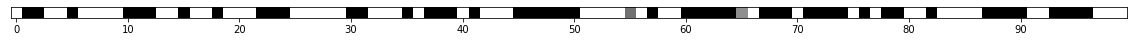

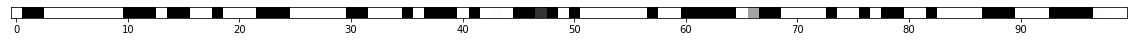

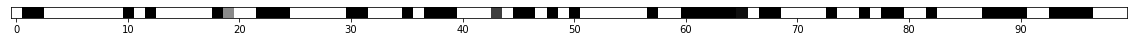

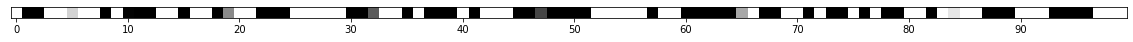

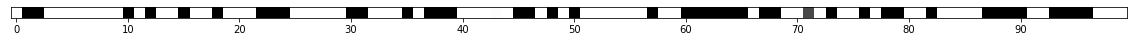

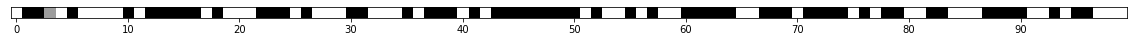

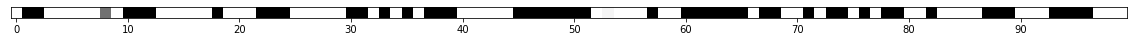

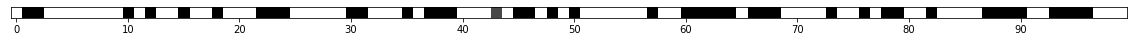

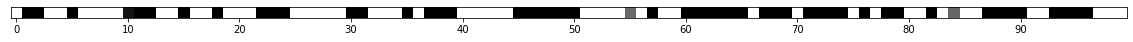

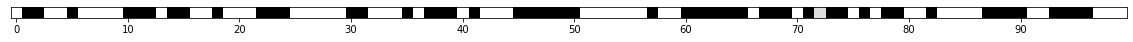

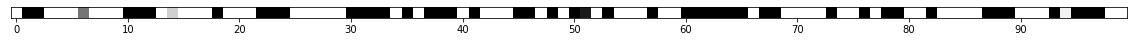

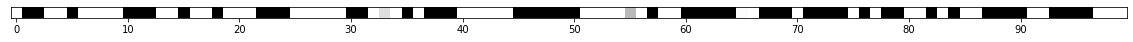

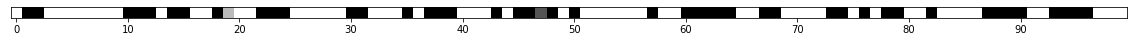

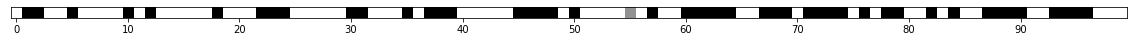

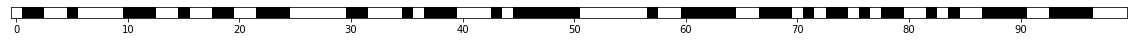

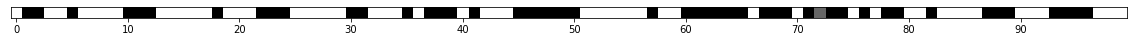

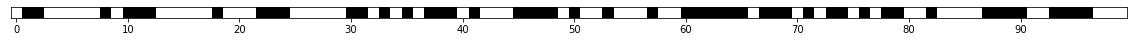

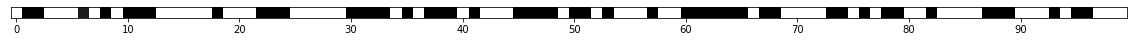

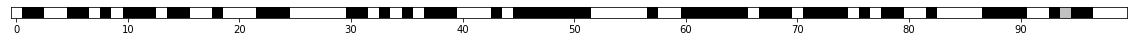

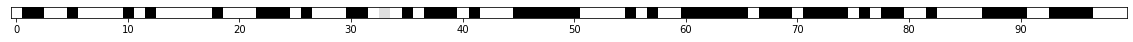

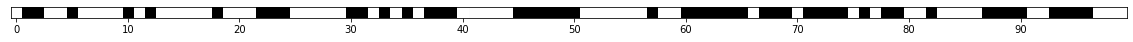

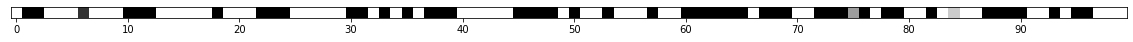

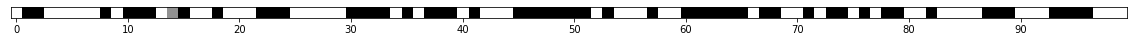

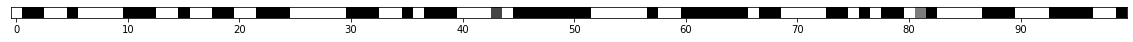

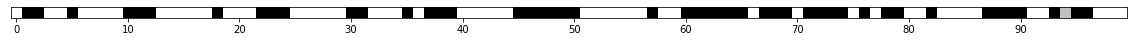

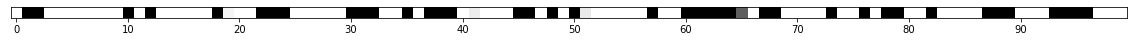

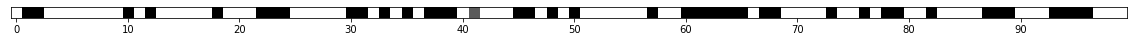

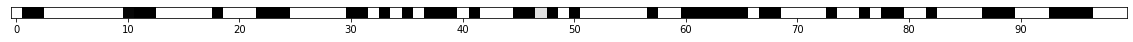

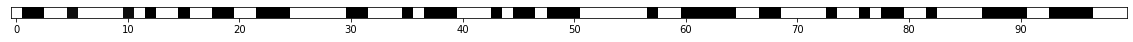

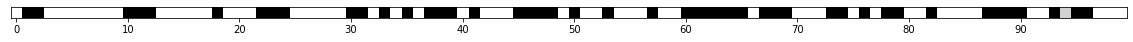

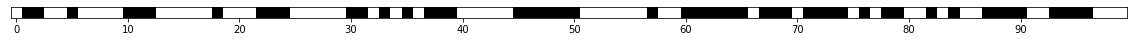

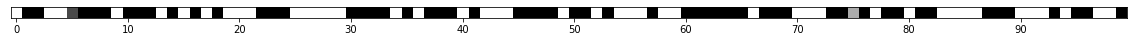

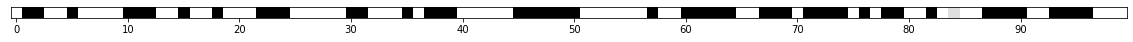

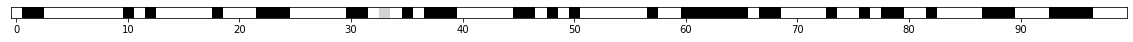

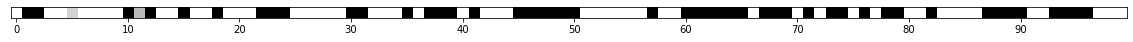

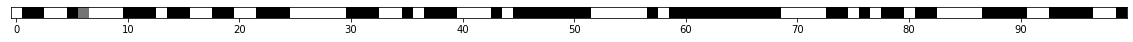

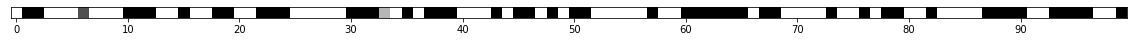

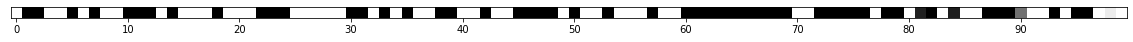

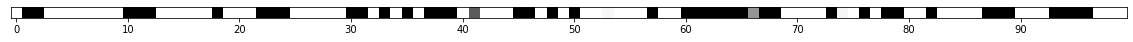

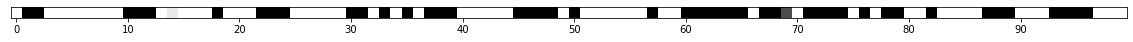

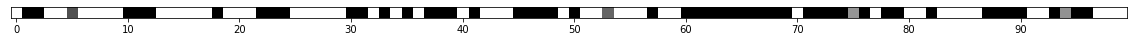

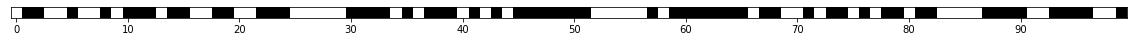

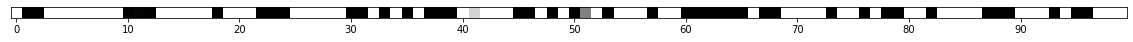

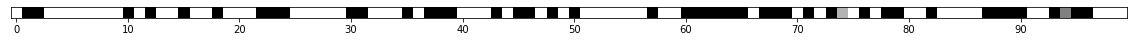

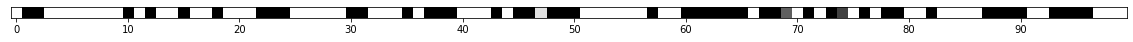

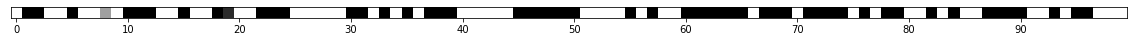

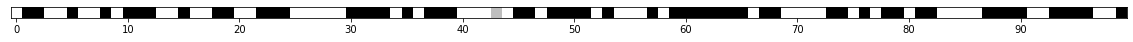

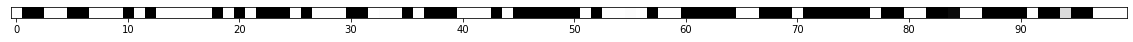

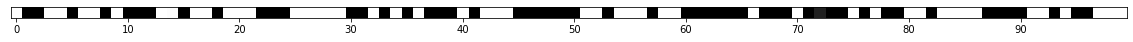

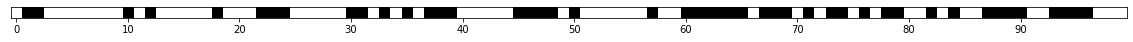

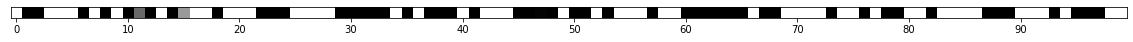

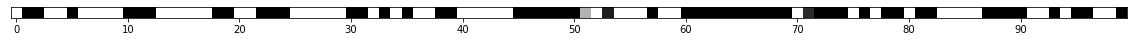

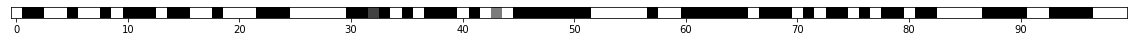

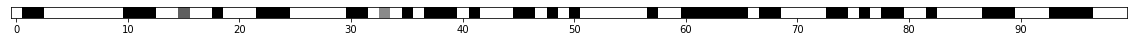

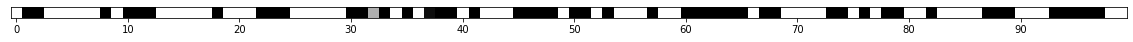

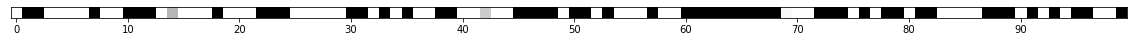

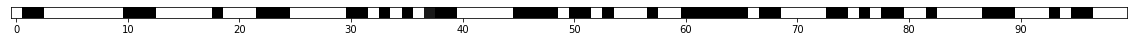

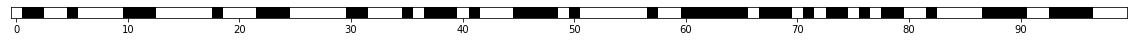

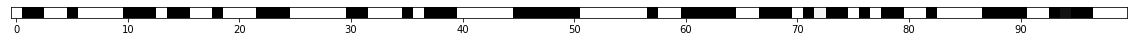

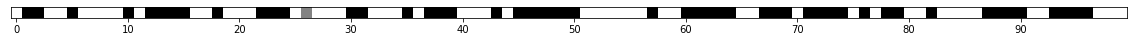

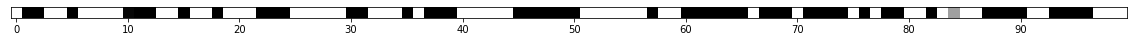

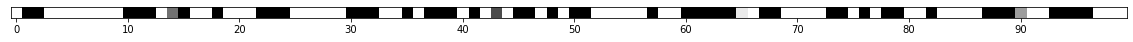

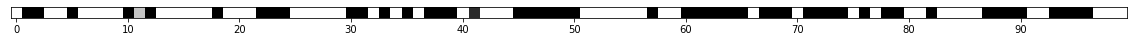

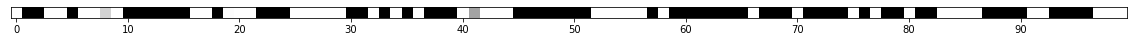

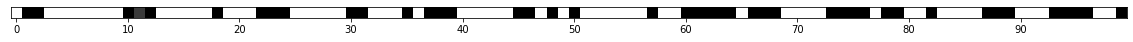

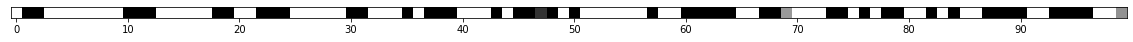

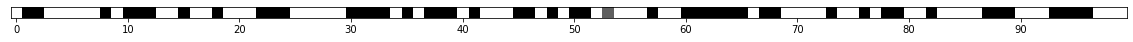

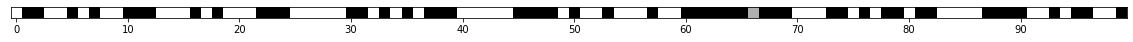

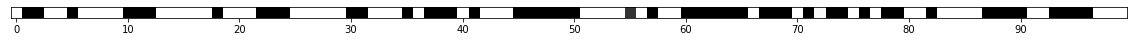

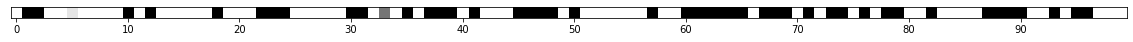

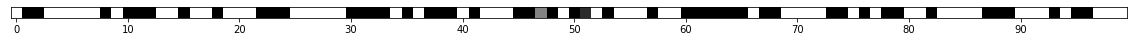

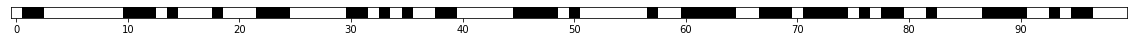

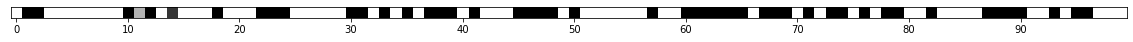

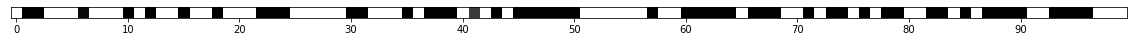

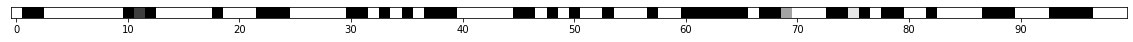

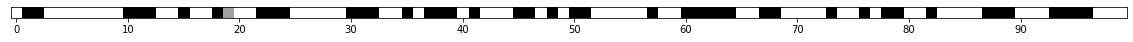

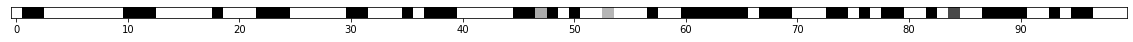

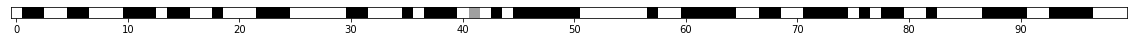

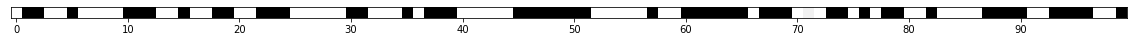

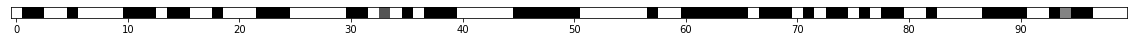

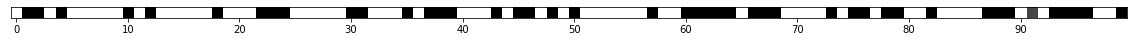

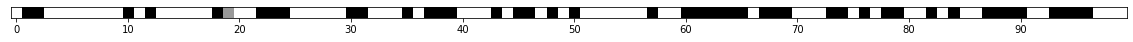

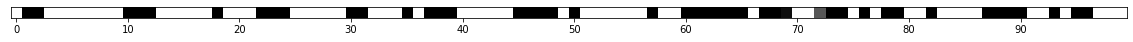

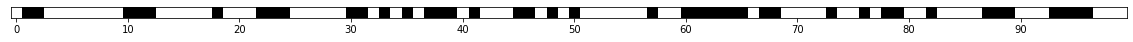

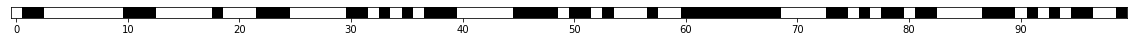

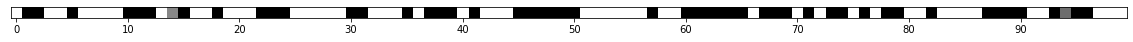

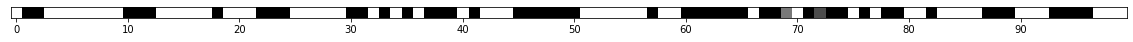

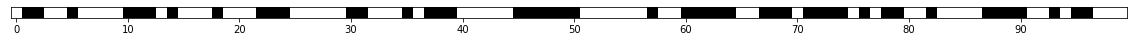

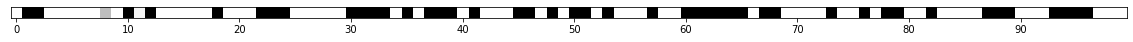

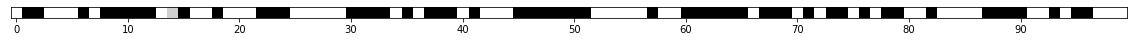

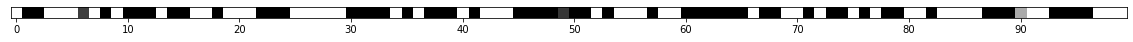

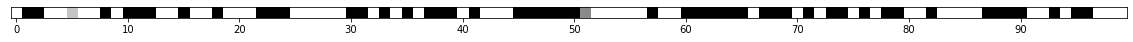

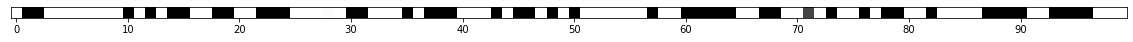

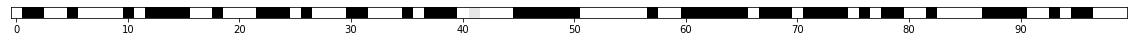

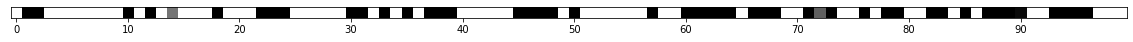

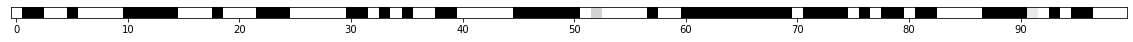

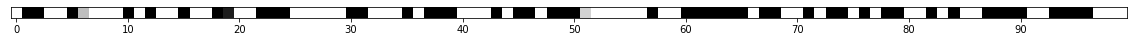

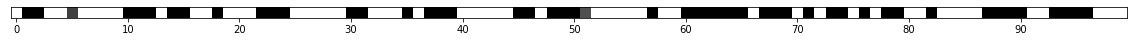

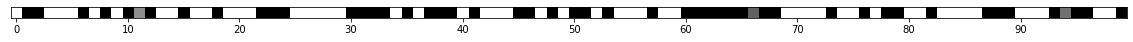

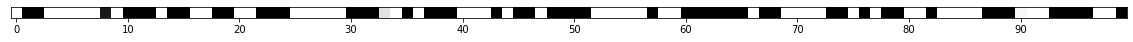

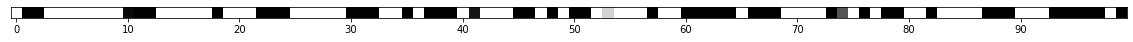

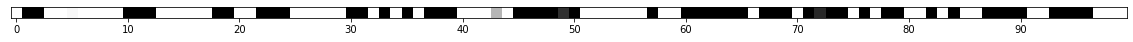

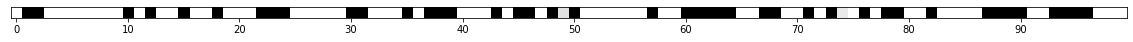

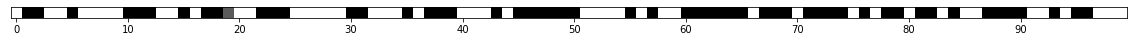

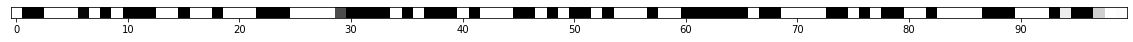

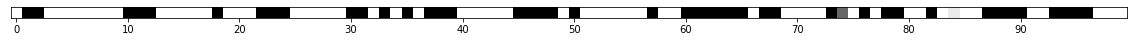

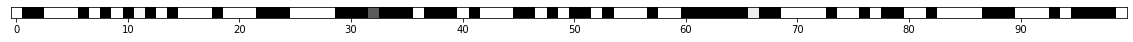

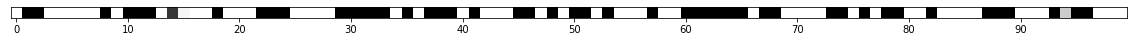

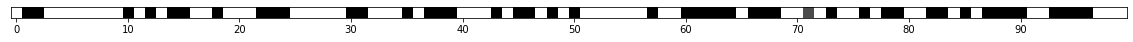

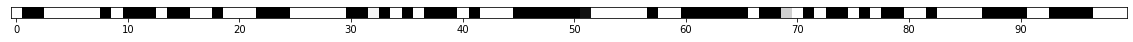

In [324]:
for i in range(1000):
    data = mnist_test.data[i].float()
    targets = mnist_test.targets[i].float()
    if targets == 4:
        spike_data = spikegen.rate(data, num_steps=num_steps, gain=0.1)
        test_spk, _, hidden_spk = net(spike_data.view(70,-1))
        _, predicted = test_spk.sum(dim=0).max(0)
        plt.figure(figsize=(20,1))
        plt.imshow(hidden_spk.sum(dim=0).unsqueeze(0).detach().numpy(), interpolation="nearest", cmap=plt.cm.gray)
        plt.yticks([])
        plt.xticks(np.arange(0,10)*10)
        #plt.colorbar()
        #plt.savefig("hidden_spike_sum.png")
        plt.show()

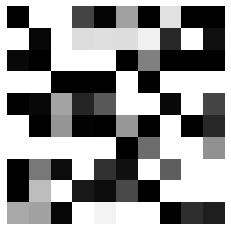

In [451]:
total_num = torch.zeros(100)
for i in range(1000):
    data = mnist_test.data[i].float()
    targets = mnist_test.targets[i].float()
    if targets == 0:
        spike_data = spikegen.rate(data, num_steps=num_steps, gain=0.02)
        test_spk, _, hidden_spk = net(spike_data.view(70,-1))
        _, predicted = test_spk.sum(dim=0).max(0)
        total_num += hidden_spk.sum(dim=0)
plt.imshow(total_num.reshape(10,10).detach().numpy(), interpolation="nearest", cmap=plt.cm.binary)
#plt.colorbar()
plt.axis('off')
plt.savefig("total spk 0.png")

In [630]:
n9 = []
for i in range(500):
    data = mnist_test.data[i].float()
    targets = mnist_test.targets[i].float()
    spike_data = spikegen.rate(data, num_steps=num_steps, gain=0.02)
    test_spk, _, hidden_spk = net(spike_data.view(70,-1))
    _, predicted = test_spk.sum(dim=0).max(0)
    n9.append(hidden_spk[:,9])

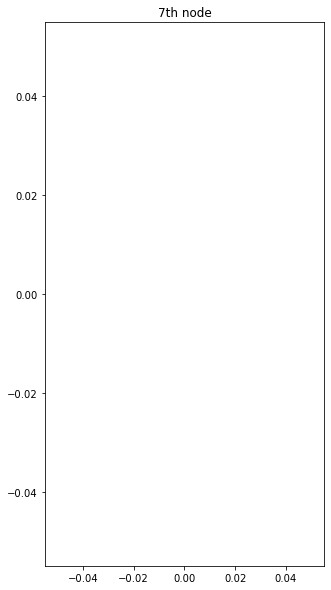

In [634]:
fig = plt.figure(figsize=(5,10))
ax = fig.add_subplot(111)
splt.raster(torch.stack(n7).reshape(70,500), ax, s=0.5, c="black")
plt.title("7th node")
plt.show()

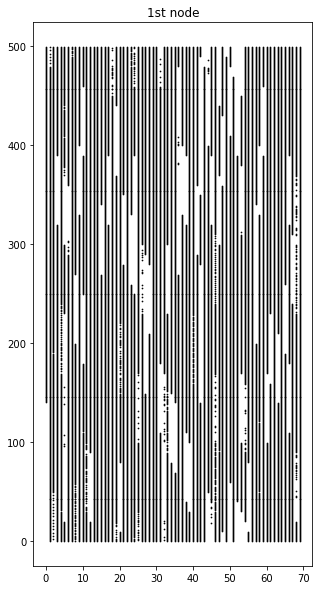

In [611]:
fig = plt.figure(figsize=(5,10))
ax = fig.add_subplot(111)
splt.raster(torch.stack(n1).reshape(70,500), ax, s=0.5, c="black")
plt.title("1st node")
plt.show()

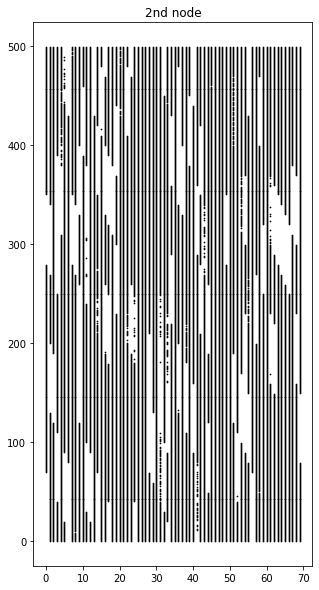

In [607]:
fig = plt.figure(figsize=(5,10))
ax = fig.add_subplot(111)
splt.raster(torch.stack(n2).reshape(70,500), ax, s=0.5, c="black")
plt.title("2nd node")
plt.show()

In [570]:
idx=4
data = mnist_test.data[idx].float()
targets = mnist_test.targets[idx].float()
spike_data = spikegen.rate(data, num_steps=num_steps, gain=0.02)
test_spk, _, hidden_spk = net(spike_data.view(70,-1))
_, predicted = test_spk.sum(dim=0).max(0)
print(targets)
print(predicted)

tensor(4.)
tensor(4)


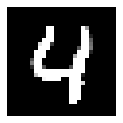

In [571]:
plt.figure(figsize=(2,2))
plt.imshow(spike_data.sum(dim=0), interpolation="nearest", cmap=plt.cm.gray)
plt.axis('off')
plt.savefig("spike_data_sum.png")

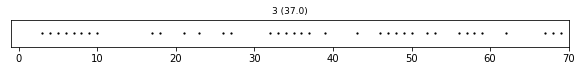

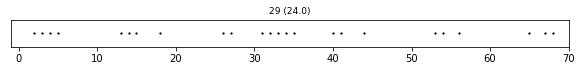

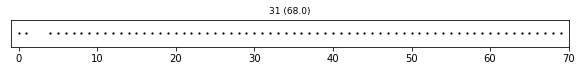

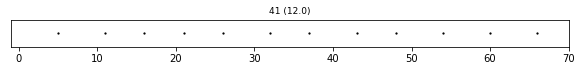

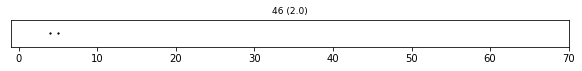

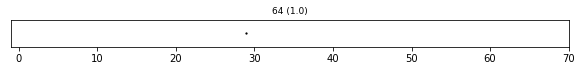

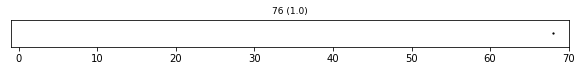

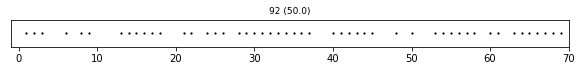

In [572]:
for i in range(100):
    if hidden_spk.sum(dim=0)[i] != 0 and hidden_spk.sum(dim=0)[i] != 70:
        fig = plt.figure(figsize=(10,0.5))
        ax = fig.add_subplot(111)
        splt.raster(hidden_spk[:,i], ax, s=1.5, c="black")
        plt.yticks([])
        plt.title(str(i)+" ("+str(hidden_spk.sum(dim=0)[i].tolist())+")", fontsize=9)
        plt.xlim(-1,70)

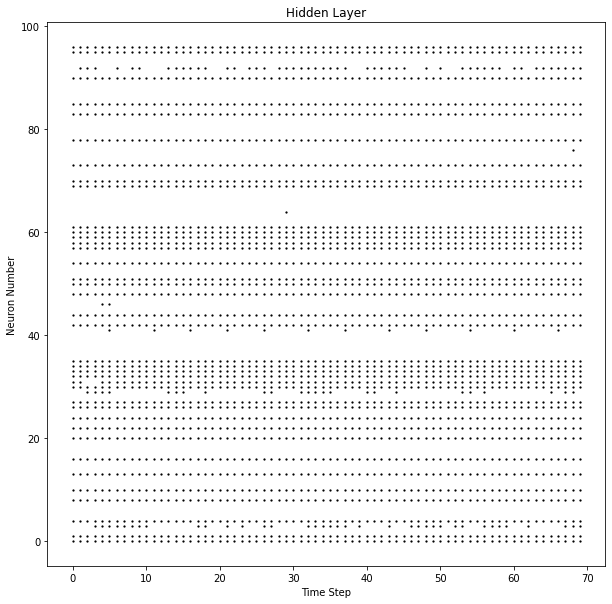

In [574]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
splt.raster(hidden_spk, ax, s=1.5, c="black")

plt.title("Hidden Layer")
plt.xlabel("Time Step")
plt.ylabel("Neuron Number")
#plt.savefig("spk {}.png".format(targets.int()),bbox_inches = 'tight')
plt.show()

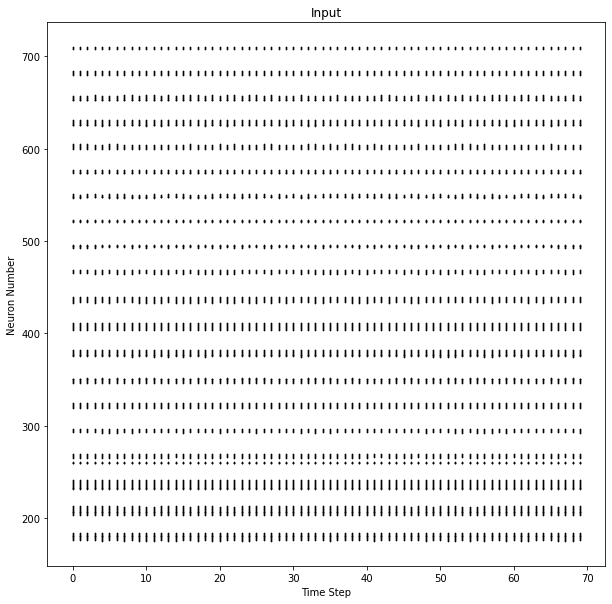

In [545]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
splt.raster(spike_data.reshape(num_steps,784), ax, s=0.5, c="black")

plt.title("Input")
plt.xlabel("Time Step")
plt.ylabel("Neuron Number")
#plt.savefig("spk {}.png".format(targets.int()),bbox_inches = 'tight')
plt.show()

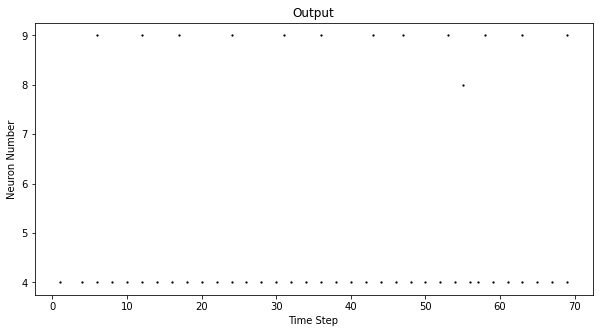

In [480]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
splt.raster(test_spk, ax, s=1.5, c="black")

plt.title("Output")
plt.xlabel("Time Step")
plt.ylabel("Neuron Number")
#plt.savefig("spk {}.png".format(targets.int()),bbox_inches = 'tight')
plt.show()

In [238]:
# list of tensors to tensor (weights through time)
weight_ten1 = torch.stack(weight_hist1)
weight_ten2 = torch.stack(weight_hist2)

In [239]:
# image plot(before, after training)
plw1 = weight_ten1[467].reshape(num_hidden, 28, 28)
plw1o = weight_ten1[0].reshape(num_hidden, 28, 28)
plw2 = weight_ten2[467].reshape(10, 10, 10)
plw2o = weight_ten2[0].reshape(10, 10, 10)

In [ ]:
# dist plot
weights1 = weight_ten1.reshape(468, num_hidden*784).tolist()
weights2 = weight_ten2.reshape(468, 10*num_hidden).tolist()

In [ ]:
# root mean square of ho weights
rms2 = torch.mul(plw2, plw2)
rms2 = rms2.mean(dim=0)
rms2 = torch.sqrt(rms2)

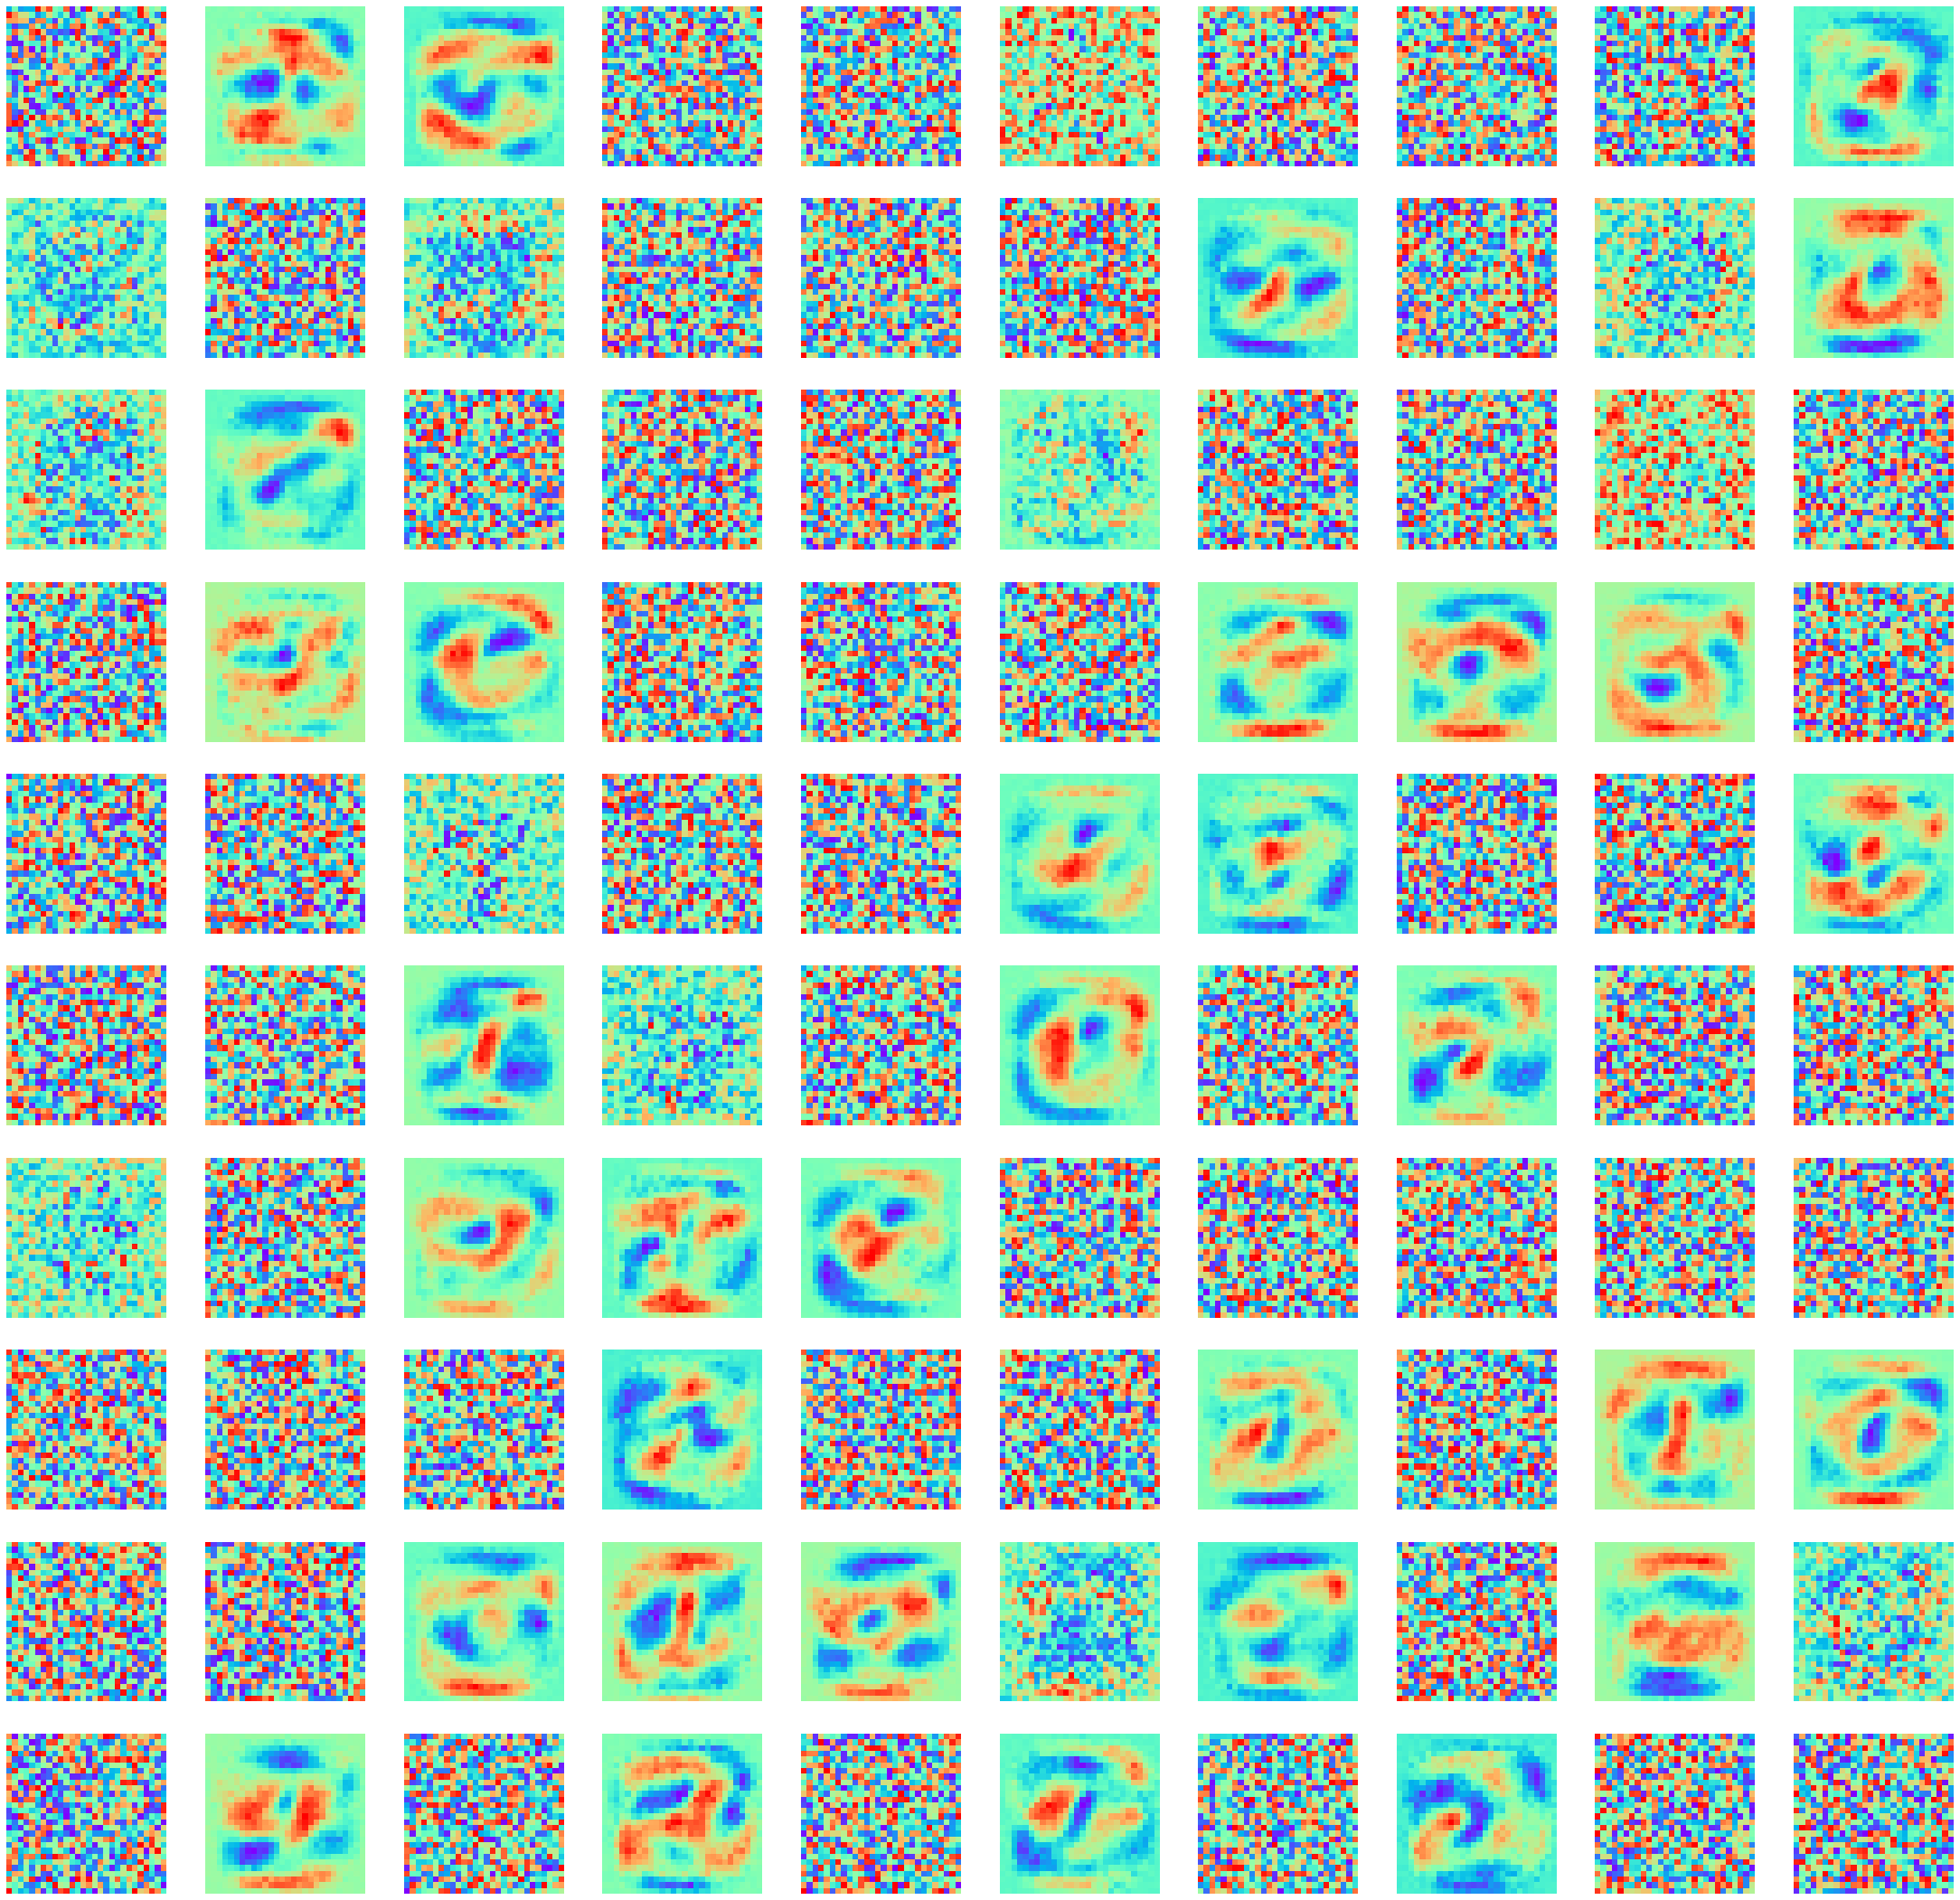

In [414]:
# ih weights image plot
fig,axes = plt.subplots(10, 10, figsize=(50, 50))
plt.subplots_adjust(0.3,0.3)
for j in range(10):
    for k in range(10):
        axes[j][k].imshow(plw1[j*10+k], interpolation="nearest", cmap=plt.cm.rainbow)
        axes[j][k].axis('off')
            #plt.title("Weights after training (node : "+str(i)+")")
plt.show()
#fig.savefig('image_10x10_100.png')

In [ ]:
# ho weights image plot
for i in range(10):
    plt.imshow(plw2[i], interpolation="nearest", cmap=plt.cm.rainbow)
    plt.axis('off')
    plt.colorbar()
    plt.savefig('to_{}'.format(i))
    plt.show()

In [ ]:
# distribution change max check
plt.hist(weights1[0],density=True,bins=200)
plt.show()
plt.hist(weights1[468*num_epochs-1],density=True,bins=200)
plt.show()
plt.hist(weights2[0],density=True, bins=200)
plt.show()
plt.hist(weights2[468*num_epochs-1],density=True, bins=200)
plt.show()

In [ ]:
# ih weights distribution change
fig, ax = plt.subplots()
camera = Camera(fig)
for i in range(468*num_epochs-1):
    p = plt.hist(weights1[i], color='lightblue', bins=200, density=True)
    plt.xlim(-0.4, 0.4)
    plt.ylim(0, 16)
    camera.snap()
animation = camera.animate(interval=10, blit=True)
animation.save('ih_weight_distribution.mp4')

In [ ]:
# ho weights distribution change
fig, ax = plt.subplots()
camera = Camera(fig)
for i in range(468*num_epochs-1):
    p = plt.hist(weights2[i], color='mediumaquamarine', bins=200,density=True)
    plt.xlim(-0.35, 0.35)
    plt.ylim(0, 16)
    camera.snap()
animation = camera.animate(interval=10, blit=True)
animation.save('ho_weight_distribution.mp4')

In [ ]:
# rms of ho weights
plt.imshow(rms2, interpolation="nearest", cmap=plt.cm.gray)
plt.axis('off')
plt.colorbar()
plt.savefig('ho_RMS.png')

In [ ]:
# save trained weight
backup = []
for i in range(num*num):
    backup.append(net.fc1.weight.data[i].clone())

In [ ]:
# delete each nodes
accuracy = []
for target in range(num*num):
    net.fc1.weight.data[target] = torch.zeros([784])
    
    total = 0
    correct = 0

    # drop_last switched to False to keep all samples
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

    with torch.no_grad():
        net.eval()
        for data, targets in test_loader:
            spike_data = spikegen.rate(data, num_steps=num_steps, gain=0.25)
            
            # forward pass
            test_spk, _ = net(spike_data.view(num_steps, data.size(0), -1))

            # calculate total accuracy
            _, predicted = test_spk.sum(dim=0).max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy.append(100*correct/total)
    print("deleted node : {}".format(target))
    print(f"Test Set Accuracy: {100 * correct / total:.2f}%\n")
    
    net.fc1.weight.data[target] = backup[target]

In [ ]:
# accuracy image plot
acc_ten = torch.tensor(accuracy)
acc_ten = acc_ten.reshape(num, num)
plt.imshow(acc_ten, interpolation="nearest", cmap=plt.cm.gray)
plt.axis('off')
plt.colorbar()
plt.savefig('destory_accuracy.png')

In [ ]:
x = accuracy
y = np.arange(100)
y_n = [13, 29, 39, 41, 67, 93] # unstructed nodes
x_n = []
for i in y_n:
    x_n.append(accuracy[i])

In [ ]:
# accuracy scatter plot
plt.vlines(80.82, 0, 99, linestyle="--", linewidth=3, color="gray", zorder=0, label='fully connected network')
plt.scatter(x, y, color ="k", zorder=5, s=25, label='network without single node')
plt.scatter(x_n, y_n, color = "r", zorder=10, s=25, label='network without unstructured node')
plt.xlabel('test accuracy(%)')
plt.ylabel('deleted node')
plt.legend(loc=1, bbox_to_anchor=(0.6,-0.15))
plt.savefig('accuracy plot.png')
plt.show()

In [ ]:
target = [0] # target nodes

In [ ]:
# delete
for i in target:
    net.fc1.weight.data[i] = torch.zeros([784])

In [ ]:
spk_plot=sum.reshape(10,10).detach().numpy()

In [ ]:
plt.imshow(spk_plot, interpolation="nearest", cmap=plt.cm.Greys)
plt.axis('off')
plt.colorbar()
plt.savefig("spk_sum.png")
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,1))
ax = fig.add_subplot(111)
splt.raster(hidden_spk[0], ax, s=100, c="black", marker="|")

plt.title("Hidden Layer ({})".format(targets.int()))
plt.xlabel("Neuron Number")
plt.yticks([])
plt.savefig("spk {}.png".format(targets.int()),bbox_inches = 'tight')
plt.show()

In [ ]:
# restore
for i in target:
    net.fc1.weight.data[i] = backup[i]